## Измерить сечение

In [1]:
%load_ext autoreload
%autoreload 2

In [62]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylib.style as pys
import pylib.preprocess as preprocess
import pylib.fit as pyfit

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

In [478]:
exp_tree = uproot.open('../trees/11/exp.root')['t']
mc_tree = uproot.open('../trees/11/mc.root')['t']
df_exp = preprocess.read_tree(exp_tree, mc=False)
df_mc = preprocess.read_tree(mc_tree, mc=True)

assert np.any( df_exp.groupby('ebeam').agg(emean = ('emeas', 'mean'), uniqs = ('emeas', 'nunique')).uniqs==1 ) #check energies in df
assert np.any( df_mc.groupby('ebeam').agg(emean = ('emeas', 'mean'), uniqs = ('emeas', 'nunique')).uniqs==1 )

In [50]:
df_exp.head()

,runnum,emeas,trigbits,tth[0],tth[1],tz[0],tz[1],tptot[0],tptot[1],trho[0],...,ksminv,ksptot,ksalign,kslen,ksdpsi,kspipt[0],kspipt[1],x1,x2,ksangle
ebeam,,,,,,,,,,,,,,,,,,,,,
525.0,8997,523.580017,2,0.695582,2.467299,-1.102452,-0.690465,197.056061,207.428711,0.253570,...,470.073883,143.049652,0.922236,0.462520,2.419611,197.766144,206.570709,-5.271232,-33.514024,0.396972
525.0,8997,523.580017,0,1.280778,1.720058,8.450068,8.336096,553.554871,95.231392,-0.150258,...,558.162903,499.915192,0.960298,1.132601,2.300664,560.759888,99.556427,-196.916097,280.149704,0.282728
525.0,8997,523.580017,3,2.534931,2.336211,20.806786,18.338717,623.882751,172.338989,-1.956100,...,525.875427,679.972534,0.823694,6.855328,1.357629,622.248657,172.494736,-347.593869,383.876926,0.602901
525.0,8997,523.580017,2,1.802251,0.874523,1.425282,0.591409,266.861115,155.472916,-0.161623,...,479.227936,165.211899,0.992088,0.765696,2.544332,266.735291,151.326035,-14.581455,-11.416929,0.125879
525.0,8997,523.580017,2,1.379263,1.389694,0.397479,1.082688,181.963669,239.301788,0.635768,...,492.575836,119.665184,0.992197,1.082190,2.636876,181.616043,240.254227,27.178113,-33.973706,0.125006


____
## Fit part

In [5]:
import numba as nb
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL, BinnedNLL, ExtendedUnbinnedNLL, ExtendedBinnedNLL, LeastSquares
from scipy.integrate import quad

In [6]:
# plot_mp_scatters(dfE, dfM, e0)
# plt.savefig('images/mp_equal.png')

In [7]:
def plot_mp_scatters(dfE, dfM, e0):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))
#     fig, ax1 = plt.subplots(1, 1, figsize=(9,9))
    
    ax1.scatter(dfE.ksptot, dfE.ksminv, marker='.', s=1, label='Exp');
    ax1.scatter(dfM.ksptot, dfM.ksminv, marker='.', s=1, alpha=0.4, label='MC');
    ax1.set_title(f'P vs M ({e0} MeV)');
    ax1.grid(ls='--')
#     mKs = 497.6
#     p0 = np.sqrt(e0**2 - mKs**2)
#     x0, y0 = (60, 60)
#     dy, dx = x0*np.cos(phi) - y0*np.sin(phi), x0*np.sin(phi) + y0*np.cos(phi)
#     ax1.arrow(p0-dx, mKs-dy, 2*dx, 2*dy)
#     x0, y0 = (20, 20)
#     dx, dy = -x0*np.sin(phi) + y0*np.cos(phi), -x0*np.cos(phi) - y0*np.sin(phi)
#     ax1.arrow(p0-dx, mKs-dy, 2*dx, 2*dy)
    ax1.set_ylabel('inv mass, MeV/c${}^2$')
    ax1.set_xlabel('momentum, MeV/c')
    ax1.legend();
#     ax1.set_aspect('equal')

    ax2.scatter(dfE.x1, dfE.x2, marker='.', s=1, label='Exp');
    ax2.scatter(dfM.x1, dfM.x2, marker='.', s=1, alpha=0.2, label='MC');
    ax2.set_title(f'x1 vs x2 ({e0} MeV)');
    ax2.grid(ls='--')
    ax2.set_xlabel('x1 axis')
#     ax2.set_ylabel('x2 axis')
    ax2.legend();
    
def plot_x1_profile(dfM, dfE, sim_energy_cut=0.005):
    dfM_soft = dfM.loc[dfM.sim_energy < sim_energy_cut]
    dfM_hard = dfM.loc[dfM.sim_energy >= sim_energy_cut]

    plt.figure(dpi=100)
    plt.grid(ls='--')
    hist_range, hist_bins, hist_norm = (-40, dfE.x1.max()), 100, 5

    count_exp = np.count_nonzero(abs(dfE.x1)<hist_norm)
    count_mc  = np.count_nonzero(abs(dfM.x1)<hist_norm)

    pys.hep_histo(dfE.x1, bins=hist_bins, range=hist_range, label='Exp')
    # plt.hist(dfM.x1, bins=hist_bins, range=hist_range, histtype='step', density=False, lw=2, label='MC', 
    #          weights=np.ones(len(dfM))*count_exp/count_mc, alpha=0.8);
    plt.hist([dfM_hard.x1, dfM_soft.x1], bins=hist_bins, range=hist_range, histtype='step', density=False, lw=2, 
             label=['MC_hard', 'MC_soft'], stacked=True, alpha=0.8, zorder=0,
             weights=[np.ones(len(dfM_hard))*count_exp/count_mc, np.ones(len(dfM_soft))*count_exp/count_mc]);
    # plt.yscale('log')
    plt.legend();
    
def plot_bkg(m, bins):
    xs = np.linspace(fit_range[0], fit_range[1], 10)
    plt.fill_between(xs, linear_norm(xs,m.values['k'])*m.values['n']*\
                     (1 -m.values['f'])*(hist_range[1]-hist_range[0])/bins, alpha=0.3, color='tomato', label='Background' )
    
def fit_data(data, fit_range, params, mc=False):
    if mc:
        params = params.copy()
        params['limit_k'] = (0, 0)
        params['limit_f'] = (1, 1)
    xmin, xmax = fit_range
    data = data[(data>xmin)&(data<xmax)]
    m = Minuit(ExtendedUnbinnedNLL(data, lambda x, n, m, sL, sR, aL, aR, k, f: 
                               (n, n * full_pdf(x, m, sL, sR, aL, aR, k, f))),
           **params, errordef=Minuit.LIKELIHOOD,
          )
    return m    

Распределения

In [8]:
kwd = {"parallel": False, "fastmath": True}

@nb.njit(**kwd)
def cruijff(x, m, sL, sR, aL, aR):
    denom = 2*np.where(x<m, (sL**2 + aL*(x-m)**2), (sR**2 + aR*(x-m)**2) )
    return np.exp(-(x-m)**2/denom)

def cruijff_norm(x, m, sL, sR, aL, aR, **kwargs):
    xmin, xmax = fit_range
    I = quad(cruijff, xmin, xmax, args=(m, sL, sR, aL, aR))[0]
    return cruijff(x, m, sL, sR, aL, aR)/I

@nb.njit(**kwd)
def linear_norm(x, k):
    xmin, xmax = fit_range
    w = xmax - xmin
    f = (1/w)*((k*(x-xmin)+1)/((k*w)/2+1))
    return f #np.where(f<0, 0, f)

def full_pdf(x, m, sL, sR, aL, aR, k, f, **kwargs):
    return f*cruijff_norm(x, m, sL, sR, aL, aR) + (1-f)*linear_norm(x, k)

In [129]:
season, nMC = 2011, 20000
energies_list = df_exp.index.unique() & df_mc.index.unique()
for i in sorted(energies_list):
    print(i, end=' ')
it = iter(energies_list)

525.0 550.0 575.0 600.0 625.0 650.0 675.0 700.0 725.0 737.5 750.0 762.5 775.0 800.0 812.5 825.0 850.0 862.5 875.0 900.0 925.0 950.0 975.0 1000.0 

[$\chi^2$-calculator](https://www.di-mgt.com.au/chisquare-calculator.html)

In [458]:
e0 = next(it)
print(f'Energy {e0} MeV')

Energy 1000.0 MeV


In [459]:
dfE = df_exp.loc[e0].copy()
dfM =  df_mc.loc[e0].copy()
assert dfM.runnum.nunique()==1

In [460]:
fit_range = (-40, 20)
hist_range = (-40, 40)
width = fit_range[1] - fit_range[0]
dataE, dataM = dfE.x1.values, dfM.x1.values

In [461]:
params = { 'n': 1000, 'm': 0, 'sL': 2, 'sR': 3, 'aL': 0, 'aR': 0, 'k': 0.1, 'f': 0.5 }
limits = [(0, None), (-5, 5), (1, 10), (1, 10), (0, 10), (0, 10), (0, 10), (0, 1)]

In [462]:
md = pyfit.fit_data(dataM, fit_range, params, limits, mc=True)
md.migrad();
assert md.valid

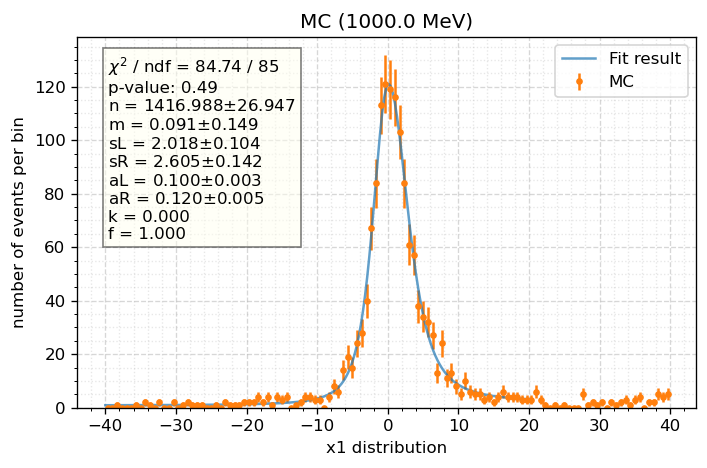

In [463]:
pys.plot_fit(dataM, full_pdf, md, 120, hist_range, fit_range, errors=True, label='MC', xtitle='x1 distribution',
           ytitle='number of events per bin', title=f'MC ({e0} MeV)', description=True)
plt.savefig(f'images/fit11/mc_{e0}.png', dpi=120)

In [464]:
params_exp = params.copy()
limits_exp = limits.copy()
for i, k in enumerate(md.parameters):
    params_exp[k] = md.values[k]
    if k not in ['n', 'k', 'f']:
        mean, std = md.values[k], 2*md.errors[k]
        if k in ['m']:
            dm = np.sqrt(dfE.emeas**2 - (497.6)**2).mean() - np.mean(np.sqrt(dfE.index**2 - (497.6)**2))
            print(f'x1: {mean:.2f} {dm:.2f}')
#             mean += dm
            std = 10
        limits_exp[i] = (mean-std, mean+std)

md2 = fit_data(dataE, fit_range, params_exp, limits_exp)
md2.migrad();
assert md2.valid

x1: 0.09 2.66


In [465]:
# md2

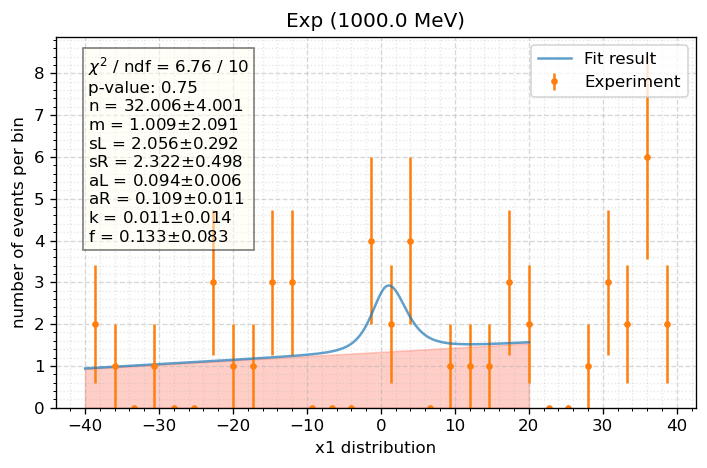

In [466]:
bins = 30
pys.plot_fit(dataE, full_pdf, md2, bins, hist_range, fit_range, errors=True, label='Experiment', xtitle='x1 distribution',
           ytitle='number of events per bin', title=f'Exp ({e0} MeV)', description=True)
plot_bkg(md2, bins)
plt.savefig(f'images/fit11/exp_{e0}.png', dpi=120)

In [467]:
if 'res_df' not in locals():
    def add_postfix(arr, post):
        return [f'{_}_{post}' for _ in arr]
    cols = add_postfix(md.parameters, 'mc') + add_postfix(md.parameters, 'mc_err') + \
        add_postfix(md2.parameters, 'exp') + add_postfix(md2.parameters, 'exp_err') + ['emeas']
    res_df = pd.DataFrame(columns=cols)
    del cols
temp_ser = pd.Series(list(md.values) + list(md.errors) + 
                     list(md2.values) + list(md2.errors) + [dfE.emeas.mean()], index=res_df.columns, name=e0)
res_df = res_df.append(temp_ser)
del temp_ser

In [468]:
res_df.tail()

,n_mc,m_mc,sL_mc,sR_mc,aL_mc,aR_mc,k_mc,f_mc,n_mc_err,m_mc_err,...,f_exp,n_exp_err,m_exp_err,sL_exp_err,sR_exp_err,aL_exp_err,aR_exp_err,k_exp_err,f_exp_err,emeas
900.0,599.030895,0.452721,2.481988,1.772670,0.093444,0.352729,0.0,1.0,17.808215,0.315662,...,0.420154,3.162931,0.887035,0.817956,0.966318,0.017086,0.081773,0.005330,0.120351,896.441162
925.0,405.966374,0.598663,2.503440,1.902946,0.074482,0.254663,0.0,1.0,14.246624,0.505270,...,0.247940,3.081243,0.921389,0.915269,1.468301,0.022334,0.053316,0.004848,0.127492,924.312866
950.0,550.007125,0.151242,2.245990,2.069276,0.086302,0.165003,0.0,1.0,16.583335,0.231991,...,0.291810,1.302237,0.959380,0.405283,0.561897,0.012307,0.023190,0.006279,0.089589,950.671753
975.0,892.005084,0.150654,2.256197,2.555553,0.093204,0.122549,0.0,1.0,21.290656,0.193511,...,0.345424,1.316761,1.005831,0.339247,0.584834,0.009888,0.019704,0.001321,0.079914,976.313477
1000.0,1416.988241,0.090684,2.017773,2.605258,0.099736,0.119683,0.0,1.0,26.947379,0.149227,...,0.132736,4.000774,2.090709,0.292325,0.498060,0.005731,0.011049,0.014243,0.082921,1002.312256


In [10]:
e0 = next(it)
print(f'Energy {e0} MeV')

dfE = df_exp.loc[e0].copy()
dfM =  df_mc.loc[e0].copy()
assert dfM.runnum.nunique()==1

phi =  0.205/(e0*2e-3-0.732) + 0.14

# x1, x2 = get_x(dfE, phi)
# dfE = dfE.assign(x1=x1, x2=x2)
# x1, x2 = get_x(dfM, phi)
# dfM = dfM.assign(x1=x1, x2=x2)

Energy 525.0 MeV


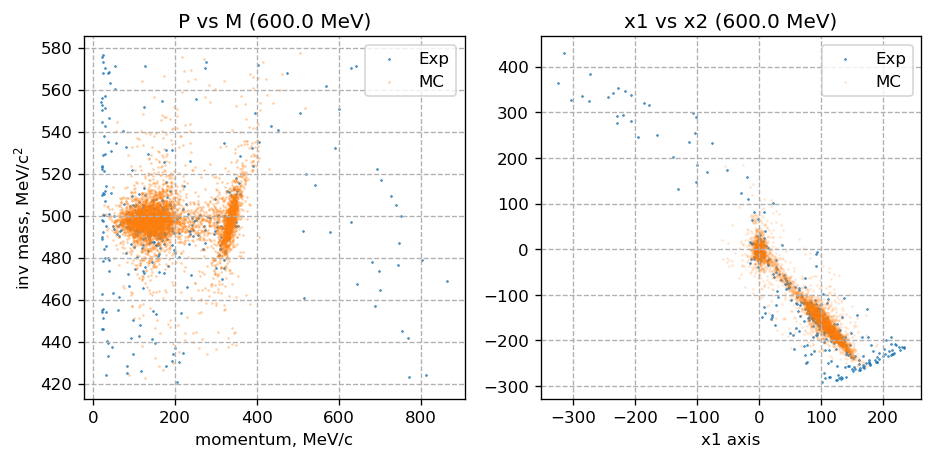

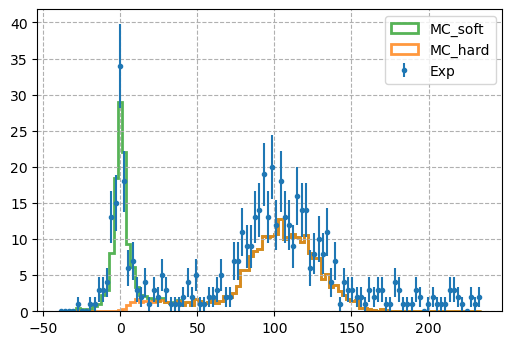

In [62]:
plot_mp_scatters(dfE, dfM, e0)
# dfM.sim_energy.hist(figsize=(4,2))
plot_x1_profile(dfM, dfE, sim_energy_cut=0.015)

Write

In [666]:
if 'res_df' not in locals():
    def add_postfix(arr, post):
        return [f'{_}_{post}' for _ in arr]
    cols = add_postfix(md.values.keys(), 'mc') + add_postfix(md.errors.keys(), 'mc_err') + \
        add_postfix(md2.values.keys(), 'exp') + add_postfix(md2.errors.keys(), 'exp_err') + ['emeas']
    res_df = pd.DataFrame(columns=cols)
    del cols

In [667]:
temp_ser = pd.Series(md.values.values() + md.errors.values() + md2.values.values() + md2.errors.values() + [dfE.emeas.mean()], index=res_df.columns, name=e0)
res_df = res_df.append(temp_ser)
del temp_ser

In [668]:
res_df.tail()

,n_mc,m_mc,sL_mc,sR_mc,aL_mc,aR_mc,k_mc,f_mc,n_mc_err,m_mc_err,...,f_exp,n_exp_err,m_exp_err,sL_exp_err,sR_exp_err,aL_exp_err,aR_exp_err,k_exp_err,f_exp_err,emeas
955.0,634.988963,0.363126,2.396996,2.221744,0.085794,0.154472,0.0,1.0,25.273140,0.328255,...,0.143605,6.556941,1.200196,0.755590,0.774462,0.013712,0.024213,0.032637,0.136401,956.036438
962.5,724.035634,-0.480484,2.077950,2.700067,0.091703,0.139588,0.0,1.0,27.018087,0.340008,...,0.361007,1.391760,1.017876,0.598289,0.930173,0.016022,0.032011,0.013849,0.099557,962.821045
975.0,825.039866,0.337782,2.741274,2.789606,0.098716,0.112744,0.0,1.0,28.724199,0.363538,...,0.363656,13.033999,1.192851,0.994703,0.925135,0.013906,0.024040,0.021105,0.085656,972.950867
978.0,928.977834,0.523876,2.787547,2.539433,0.085592,0.122629,0.0,1.0,30.731175,0.313145,...,0.538142,3.601249,1.086978,0.686598,0.984935,0.020183,0.035828,0.096259,0.231535,976.210022
987.5,1152.017160,1.017823,2.933601,1.900634,0.093444,0.137355,0.0,1.0,34.173995,0.245381,...,0.324952,10.001009,0.913475,0.486823,0.511608,0.010574,0.024050,0.030283,0.088274,987.769592


In [469]:
# res_df.to_csv('images/fit11.csv')

Triggers

In [477]:
df_exp

,runnum,emeas,trigbits,tth[0],tth[1],tz[0],tz[1],tptot[0],tptot[1],trho[0],...,ksminv,ksptot,ksalign,kslen,ksdpsi,kspipt[0],kspipt[1],x1,x2,ksangle
ebeam,,,,,,,,,,,,,,,,,,,,,
525.0,8997,523.580017,2,0.695582,2.467299,-1.102452,-0.690465,197.056061,207.428711,0.253570,...,470.073883,143.049652,0.922236,0.462520,2.419611,197.766144,206.570709,-5.271232,-33.514024,0.396972
525.0,8997,523.580017,0,1.280778,1.720058,8.450068,8.336096,553.554871,95.231392,-0.150258,...,558.162903,499.915192,0.960298,1.132601,2.300664,560.759888,99.556427,-196.916097,280.149704,0.282728
525.0,8997,523.580017,3,2.534931,2.336211,20.806786,18.338717,623.882751,172.338989,-1.956100,...,525.875427,679.972534,0.823694,6.855328,1.357629,622.248657,172.494736,-347.593869,383.876926,0.602901
525.0,8997,523.580017,2,1.802251,0.874523,1.425282,0.591409,266.861115,155.472916,-0.161623,...,479.227936,165.211899,0.992088,0.765696,2.544332,266.735291,151.326035,-14.581455,-11.416929,0.125879
525.0,8997,523.580017,2,1.379263,1.389694,0.397479,1.082688,181.963669,239.301788,0.635768,...,492.575836,119.665184,0.992197,1.082190,2.636876,181.616043,240.254227,27.178113,-33.973706,0.125006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525.0,9156,523.580017,2,1.669114,0.968222,-0.709835,-2.891790,190.624863,254.594177,-0.786013,...,495.769928,169.389801,0.996872,1.321099,2.404866,190.031662,252.069336,-5.913043,3.278343,0.079119
525.0,9156,523.580017,2,1.160381,1.934089,-0.006763,0.009495,183.134644,238.737076,-0.816022,...,496.866608,98.854141,0.999996,0.886180,2.748357,182.949585,238.683670,44.986715,-45.565250,0.002868
525.0,9156,523.580017,2,1.522165,1.603202,-1.189078,-1.694334,131.229919,296.491547,-0.256148,...,493.206207,163.627335,0.999970,4.647543,3.128160,132.400986,296.006714,-3.621397,-2.597629,0.007705


In [480]:
trig_df = pd.DataFrame()
for ee in energies_list:
    dfE = df_exp.loc[ee].copy()
    dfM = df_mc.loc[ee].copy()
#     print(ee)
    assert dfM.runnum.nunique()==1
    xmin, xmax = fit_range
    dfE = dfE.query('x1<@xmax&x1>@xmin')[['trigbits']]
    dfE[ee] = 1
    trig_df = trig_df.append(pd.pivot_table(dfE, values=ee, columns='trigbits', aggfunc='sum'))
trig_df = trig_df.fillna(0).drop(0, axis=1).rename({1: 'TF', 2: 'CF', 3:'TC'}, axis=1)

In [481]:
t, c, tc = trig_df['TF'] + trig_df['TC'], trig_df['CF'] + trig_df['TC'], trig_df['TC']

trig_df['effT'] = (tc + 1)/(c + 2)
trig_df['effC'] = (tc + 1)/(t + 2)

trig_df['effT_err'] = np.sqrt( (tc+1)*(tc+2)/(c+2)/(c+3) - ((tc+1)/(c+2))**2 )
trig_df['effC_err'] = np.sqrt( (tc+1)*(tc+2)/(t+2)/(t+3) - ((tc+1)/(t+2))**2 )

trig_df['eff_trig']  = 1 - (1-trig_df.effT)*(1-trig_df.effC)
trig_df['eff_trig_err']  = np.sqrt( (trig_df.effT_err*(1-trig_df.effC))**2 
                             + (trig_df.effC_err*(1-trig_df.effT))**2 )

In [483]:
# trig_df.to_csv('images/triggers11.csv')

Если не фиксировать параметры в экспериментальном распределении, то провожу статистический тест.

Гипотеза $H_0$ - параметры распределений в эксперименте и моделировании одинаковы

Проверяем гипотезу на уровне значимости 5% = $2 \cdot \sigma$

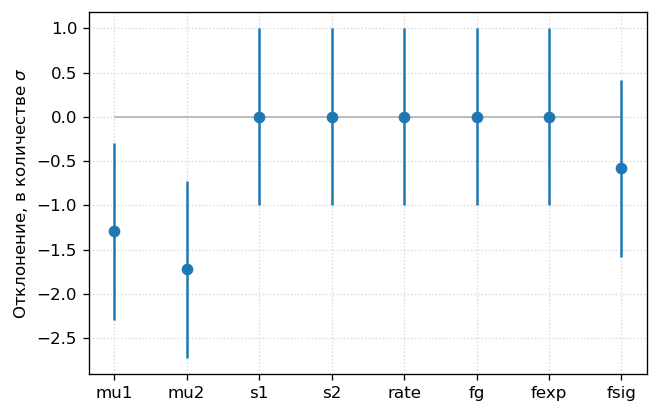

In [639]:
valsE, errsE = m_exp.values, m_exp.errors
valsM, errsM = m_mc.values, m_mc.errors
x0, ex = [], []
var =  ['mu1', 'mu2', 's1', 's2', 'rate', 'fg', 'fexp', 'fsig']
for k in var:
    error = (np.sqrt(errsE[k]**2 + errsM[k]**2))
    x0.append((valsE[k] - valsM[k])/error)
    
plt.hlines(y=0, xmin=0, xmax=len(x0)-1, zorder=-1, color='k', lw=1, alpha=0.3)
plt.errorbar(range(len(x0)), x0, yerr=1, fmt='o')
plt.grid(ls=':', alpha=0.5)
plt.ylabel('Отклонение, в количестве $\\sigma$')
plt.xticks(range(len(x0)), var);
# del valsE, valsM, errsE, errsM

In [484]:
from pylib.radcors import RadCor

In [485]:
cs_approx = pd.read_csv('../data/cross_sections_kskl.txt', header=None, sep=' ')[[1, 2]]
cs_approx[1] /= 2

In [486]:
cs_approx

,1,2
0,497.5,0.000000
1,498.0,0.067593
2,498.5,0.292279
3,499.0,0.642567
4,499.5,1.128050
...,...,...
550,1046.0,0.368000
551,1047.0,0.381000
552,1048.0,0.394000
553,1049.0,0.409000


In [77]:
r = RadCor(cs_approx[1], cs_approx[2])

In [78]:
r.F_Radcor(1059.947/2)

(1.8978407634915915, 1.3592433366270849e-05)

In [44]:
np.extract(r.y>1000, r.y)

array([1009.83788297, 1042.80429893, 1074.80668805, 1105.84505034,
       1135.91938579, 1165.02969441, 1193.1759762 , 1220.35823115,
       1246.57645926, 1271.10635807, 1291.33171835, 1307.01606621,
       1318.15940165, 1324.76172467, 1326.82303528, 1324.34333347,
       1317.32261923, 1305.76089258, 1289.65815351, 1269.01440203,
       1243.82963812, 1214.10386179, 1179.83707305, 1141.02927189,
       1097.68045831, 1049.79063231])

In [45]:
np.extract(r.y>1000, r.x)

array([509.02958296, 509.08582858, 509.14207421, 509.19831983,
       509.25456546, 509.31081108, 509.36705671, 509.42330233,
       509.47954795, 509.53579358, 509.5920392 , 509.64828483,
       509.70453045, 509.76077608, 509.8170217 , 509.87326733,
       509.92951295, 509.98575858, 510.0420042 , 510.09824982,
       510.15449545, 510.21074107, 510.2669867 , 510.32323232,
       510.37947795, 510.43572357])

In [10]:
# dfExp = uproot.open('../trees/exp2019.root')['t'].pandas.df()
dfMC  = uproot.open('../trees/19/mc_mcgpj.root')['t'].pandas.df()

In [8]:
dfExp = uproot.open('../trees/exp2019_runs.root')['t'].pandas.df()


In [11]:
dfMC

,ebeam,runnum,emeas,trigbits,tth[0],tth[1],tz[0],tz[1],tptot[0],tptot[1],...,tchi2r[1],tchi2z[0],tchi2z[1],tnhit[0],tnhit[1],ksminv,ksptot,ksalign,kslen,name
entry,,,,,,,,,,,,,,,,,,,,,
0,537.453979,0,537.453979,1,2.005805,0.816097,0.241445,-0.888369,143.569092,311.319489,...,1.170788,0.991979,0.694018,20,9,499.395172,216.374481,0.999027,2.772172,b'/store17/petrov/data/kskl20/tr_ph/19/tr_ph_k...
1,537.453979,0,537.453979,1,2.100847,1.231824,0.373388,1.236971,163.939804,266.816101,...,0.386262,0.529379,2.069548,20,13,505.448303,115.481873,0.993188,1.221455,b'/store17/petrov/data/kskl20/tr_ph/19/tr_ph_k...
2,537.453979,0,537.453979,3,1.064023,2.009341,0.545712,0.701725,207.671967,250.174591,...,1.026735,0.957598,2.091434,21,16,497.253052,201.719330,0.996737,0.513309,b'/store17/petrov/data/kskl20/tr_ph/19/tr_ph_k...
3,537.453979,0,537.453979,3,1.970497,1.382862,-1.777212,-1.631636,237.645996,216.820862,...,0.688015,1.209268,1.051637,16,17,497.766693,194.066284,0.999999,0.949363,b'/store17/petrov/data/kskl20/tr_ph/19/tr_ph_k...
4,537.453979,0,537.453979,1,2.077082,0.747478,-3.668395,-3.670606,234.502472,192.621414,...,0.258133,0.670550,1.641627,15,11,496.693756,116.323097,0.992242,0.680561,b'/store17/petrov/data/kskl20/tr_ph/19/tr_ph_k...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180964,987.804504,0,987.804504,0,2.296050,2.302264,-3.326244,-2.858969,217.647888,326.898590,...,1.985037,0.435221,0.937301,8,9,488.565735,378.995667,0.985185,2.075993,b'/store17/petrov/data/kskl20/tr_ph/19/tr_ph_k...
180965,987.804504,0,987.804504,2,1.565175,2.376279,3.020628,4.328830,392.622803,558.588196,...,0.396961,0.814028,2.583056,18,13,502.476227,851.478271,0.999599,0.804988,b'/store17/petrov/data/kskl20/tr_ph/19/tr_ph_k...
180966,987.804504,0,987.804504,3,1.524234,1.348975,4.602494,5.106483,106.665916,370.123230,...,0.786073,0.843128,0.852886,22,17,425.076477,383.258636,0.935170,0.304142,b'/store17/petrov/data/kskl20/tr_ph/19/tr_ph_k...
